In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.0, rc={"lines:linewidth": 2.5})

warnings.filterwarnings('ignore')
payoff_types = {
    'payoff1' : '$(S_2-S_1)^+$',
    'payoff2' : '$|S_2-1.1\cdot S_1|$', #quit
    'payoff3' : '$\log(S_2/S_1)$',
    'payoff4' : '$\sqrt{S_1\cdot S_2}$',
    'payoff6' : '1 if $S_2 > S_1$',
    'payoff7' : r'$\frac{S_1+S_2}{2} - \sqrt{S_1\cdot S_2}$'
}
hedge_types = {'super' : 'Super-Hedge',
               'sub' : 'Sub-Hedge',
               'delta': 'Delta-Hedge'}

In [4]:
def gapData(modelName):
    if modelName == 'BS':
        df = pd.read_csv('resultBS.csv',index_col=0)
    elif modelName == 'Heston':
        df = pd.read_csv('result_hestonModel.csv',index_col=0)
    elif modelName == 'LocVol':
        df = pd.read_csv('resultLocVol.csv',index_col=0)
    elif modelName == 'sub':
        df = pd.read_csv('sub_gap.csv',index_col=0)
    elif modelName == 'super':
        df = pd.read_csv('super_gap.csv',index_col=0)
    df.columns = np.array(pd.to_numeric(df.columns).astype('int'))
    plot_sample = list(df.count()[df.count() > 20].index)
    # plot_sample.remove(0)
    df = df.loc[:, plot_sample]
    df = df.T.sort_index().T
    return df
df_bs = gapData('BS')
df_heston = gapData('Heston')
df_locVol = gapData('LocVol')
df_sub = gapData('sub')
df_super = gapData('super')

In [ ]:
plt.rcParams.update({
    'axes.titlesize': 15,
    'axes.labelsize': 15, 
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15, 
})

In [ ]:
def hist_subplots(df_bs, df_heston, df_locVol):

    filtered_heston = df_heston[(df_heston<=0.22) & (df_heston>=-0.22)].stack()
    filtered_bs = df_bs[(df_bs<=0.22) & (df_bs>=-0.22)].stack()
    filtered_locVol = df_locVol[(df_locVol<=0.22) & (df_locVol>=-0.22)].stack()
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    filtered_bs.hist(bins=100, ax=axes[0])
    axes[0].set_xlim(-0.22, 0.22)
    axes[0].set_title(fr'Black-Scholes')
    axes[0].set_xlabel('Payoff Gap')
    axes[0].set_ylabel('Frequency')

    filtered_locVol.hist(bins=100, ax=axes[1])
    axes[1].set_xlim(-0.22, 0.22)
    axes[1].set_title(fr'Local Volatility')
    axes[1].set_xlabel('Payoff Gap')
    axes[1].set_ylabel('Frequency')

    filtered_heston.hist(bins=100, ax=axes[2])
    axes[2].set_xlim(-0.22, 0.22)
    axes[2].set_title(fr'Heston')
    axes[2].set_xlabel('Payoff Gap')
    axes[2].set_ylabel('Frequency')
    # plt.suptitle('Payoff Gap of Delta Hedge',fontsize=17)
    plt.tight_layout()
    plt.savefig('CompareModels_hist.png')
    plt.show()

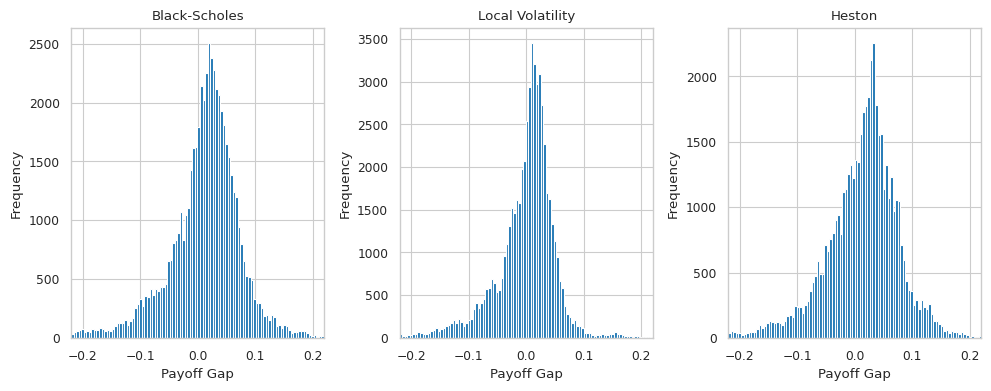

In [8]:
hist_subplots(df_bs, df_heston, df_locVol)

In [ ]:
# df_sub = gapData('sub')
def aggregate_dataframe_stats(names, dfs):
    if not dfs:
        raise ValueError("At least add one DataFrame")

    if len(dfs) != len(names):
        raise ValueError("Length of dfs and names should be the same")

    stats = {}

    for df, name in zip(dfs, names):
        stacked_values = df.stack().values
        stats[name] = {
            'Median': np.median(stacked_values),
            'Mean': np.mean(stacked_values),
            'Min': np.min(stacked_values),
            'Max': np.max(stacked_values),
            'Std': np.std(stacked_values),
            'Skewness': np.mean((stacked_values - np.mean(stacked_values))**3),
            'Q25': np.percentile(stacked_values, 25),
            'Q75': np.percentile(stacked_values, 75),
            'Q5': np.percentile(stacked_values, 5),
            'Q95': np.percentile(stacked_values, 95)
        }

    return pd.DataFrame(stats)
names = ["Black-Scholes", "LocalVolatility", "Heston", "Super-Hedging","Sub-Hedging"]
result = aggregate_dataframe_stats(names,[df_bs,df_locVol,df_heston, df_super,df_sub])
print(result)

          Black-Scholes  LocalVolatility      Heston  Super-Hedging  \
Median         0.017375         0.006825    0.018836       0.025400   
Mean           0.001365        -0.012385    0.021321       0.052974   
Min           -1.469029        -1.471793   -1.319117      -0.040909   
Max            0.381178         0.360007  171.981836     217.953318   
Std            0.100645         0.094209    1.365235       0.928247   
Skewness      -0.003883        -0.003717  296.565843     185.632186   
Q25           -0.020518        -0.026549   -0.024583       0.007736   
Q75            0.047210         0.027255    0.050836       0.057804   
Q5            -0.135758        -0.139276   -0.140555      -0.000254   
Q95            0.102207         0.063345    0.113539       0.145980   

          Sub-Hedging  
Median      -0.010332  
Mean        -0.031019  
Min         -1.424782  
Max          0.062927  
Std          0.072417  
Skewness    -0.002507  
Q25         -0.035370  
Q75         -0.000176  
Q5

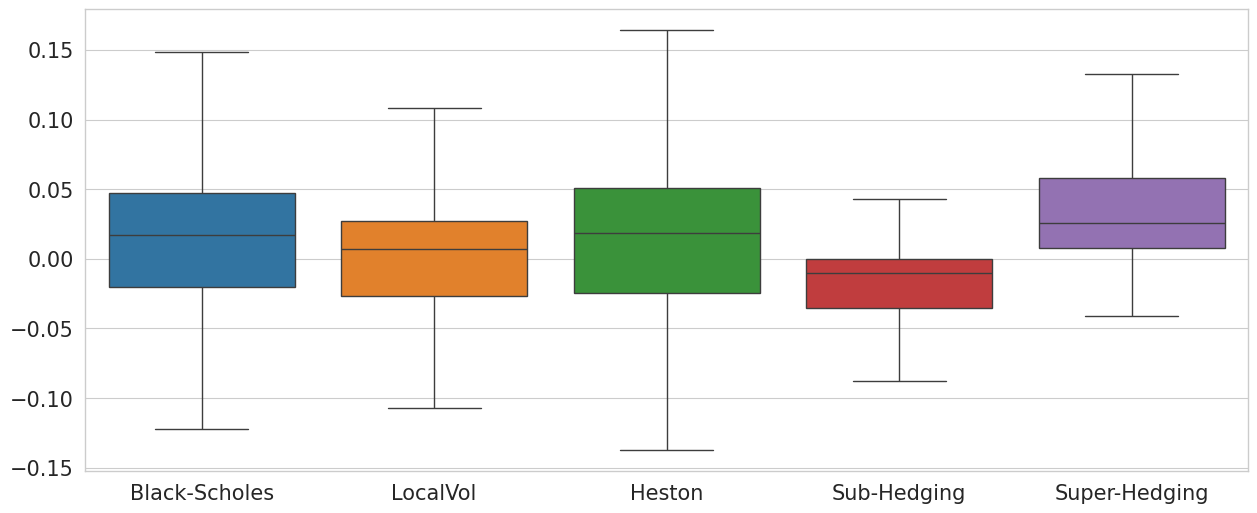

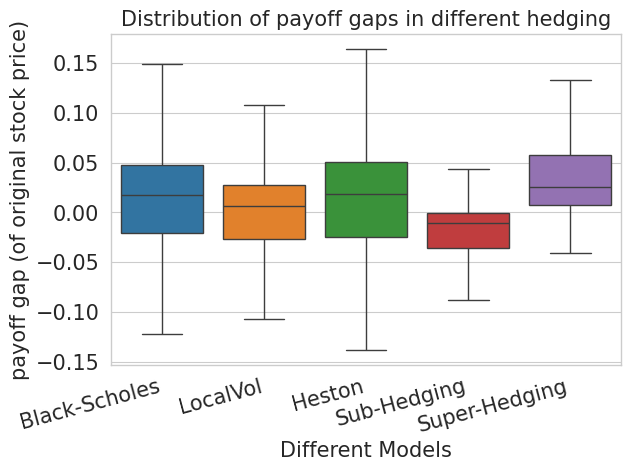

In [ ]:
def plot_boxplots(names, dfs):
    stack_all = pd.DataFrame()
    for i in range(len(dfs)):
        df = dfs[i].stack().reset_index(drop=True)
        df.name = names[i]
        stack_all = pd.concat([stack_all,df])
    plt.figure(figsize=(15, 6))
    ax = sns.boxplot(data=stack_all, showfliers=False)
    i = 0
    column = stack_all.columns[0]
    median = stack_all[column].median()
    Q1 = stack_all[column].quantile(0.25)
    Q3 = stack_all[column].quantile(0.75)
    fig, ax = plt.subplots()
    sns.boxplot(data=stack_all, showfliers=False, ax=ax)

    plt.title('Distribution of payoff gaps in different hedging')
    plt.xlabel('Different Models')
    plt.ylabel('payoff gap (of original stock price)')
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.savefig('DifferentModelsBoxplot.png', bbox_inches='tight')
    plt.show()
names = ["Black-Scholes", "LocalVol", "Heston","Sub-Hedging","Super-Hedging"]
plot_boxplots(names, [df_bs,df_locVol,df_heston,df_sub,df_super])